In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import StandardScaler


from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

RAND = 10
N_FOLDS = 5

## 1. Загрузка датасета и преобразование признаков

In [3]:
df = pd.read_csv('nyra_2019_mod.csv')

In [4]:
df.isna().sum()

track_id           0
race_number        0
program_number     0
trakus_index       0
latitude           0
longitude          0
distance_id        0
course_type        0
track_condition    0
run_up_distance    0
race_type          0
purse              0
weight_carried     0
jockey             0
odds_new           0
month              0
day                0
day_of_week        0
odds_log           0
season             0
time_of_day        0
name_of_day        0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 22 columns):
 #   Column           Dtype  
---  ------           -----  
 0   track_id         object 
 1   race_number      int64  
 2   program_number   object 
 3   trakus_index     int64  
 4   latitude         float64
 5   longitude        float64
 6   distance_id      float64
 7   course_type      object 
 8   track_condition  object 
 9   run_up_distance  float64
 10  race_type        object 
 11  purse            int64  
 12  weight_carried   float64
 13  jockey           object 
 14  odds_new         float64
 15  month            int64  
 16  day              int64  
 17  day_of_week      int64  
 18  odds_log         float64
 19  season           object 
 20  time_of_day      object 
 21  name_of_day      object 
dtypes: float64(7), int64(6), object(9)
memory usage: 877.6+ MB


Для дальнейшей работы следует перевести признаки типа "object" в "category"

In [6]:
# список признаков object
category_features = [
    'track_id', 'program_number', 'course_type', 'track_condition',
    'race_type', 'jockey', 'season', 'time_of_day', 'name_of_day'
]

In [7]:
# цикл для перевода
for col in df.columns:
    if col in category_features:
        df[col] = df[col].astype('category')

Также, чтоб датасет был поменьше, то стоит перевести из int64 -> int16 и из float64->float16

In [8]:
# список данных типа int64
list_int64 = ['race_number', 'trakus_index', 'purse', 'post_time', 'weight_carried',
             'month', 'day', 'day_of_week', 'hours', 'minutes']

# список данных типа float64
list_float64 = ['latitude', 'longitude', 'distance_id', 'run_up_distance', 'odds_new',
               'odds_log']

In [9]:
# перевод
for col in df.columns:
    if col in list_int64:
        df[col] = df[col].astype('int16')
    elif col in list_float64:
        df[col] = df[col].astype('float16')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5228430 entries, 0 to 5228429
Data columns (total 22 columns):
 #   Column           Dtype   
---  ------           -----   
 0   track_id         category
 1   race_number      int16   
 2   program_number   category
 3   trakus_index     int16   
 4   latitude         float16 
 5   longitude        float16 
 6   distance_id      float16 
 7   course_type      category
 8   track_condition  category
 9   run_up_distance  float16 
 10  race_type        category
 11  purse            int16   
 12  weight_carried   int16   
 13  jockey           category
 14  odds_new         float16 
 15  month            int16   
 16  day              int16   
 17  day_of_week      int16   
 18  odds_log         float16 
 19  season           category
 20  time_of_day      category
 21  name_of_day      category
dtypes: category(9), float16(6), int16(7)
memory usage: 179.5 MB


Для некоторых моделей следует бинаризовать категориальный признаки, используя метод pd.get_dummies()

In [11]:
df_label = pd.get_dummies(df, columns=category_features, drop_first=True)

## 2. Обучение

### Один из важных признаков - это "odds". Чем лучше он сформирован, тем более понятны шансы на выигрыш и вообще шансы лошади на скачках. Поэтому в данном случае будут применены модели по улучшению показателей признака odds.

Будут применены следующие модели:

- Линейная регрессия;
- CatBoost;
- LightGBMRegression.

Метрики, по которым будут оцениваться результаты

In [11]:
metrics = pd.DataFrame()

In [12]:
def r2_adjusted(y_true: list, y_pred: list, X_test: np.array) -> float:
    """
    Коэффициент детерминации (множеств регрессия)
    """
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def huber_loss(y_true, y_pred, delta):
    """
    Функция ошибки Хьюбера (MSE & MAE)
    """
    assert len(y_true) == len(y_pred), 'Разные размеры данных'
    huber_sum = 0
    for i in range(len(y_true)):
        if abs(y_true[i] - y_pred[i]) <= delta:
            huber_sum += 0.5 * (y_true[i] - y_pred[i])**2
        else:
            huber_sum += delta * (abs(y_true[i] - y_pred[i]) -
                                  0.5 * delta)
    huber_sum /= len(y_true)
    return huber_sum


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


def get_metrics(y_test, y_pred, X_test, name, delta):  # выводим метрики
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MAE'] = [mean_absolute_error(y_test, y_pred)]
    df_metrics['MSE'] = [mean_squared_error(y_test, y_pred)]
    df_metrics['RMSE'] = [np.sqrt(mean_squared_error(y_test, y_pred))]
    try:
        df_metrics['RMSLE'] = [rmsle(y_test, y_pred)]
    except:
        df_metrics['RMSLE'] = 0

    df_metrics['R2 adjusted'] = [r2_adjusted(y_test, y_pred, X_test)]
    df_metrics['Huber_loss'] = [huber_loss(y_test, y_pred, delta)]

    return df_metrics

Такие метрики, как WAPE, MPE, WAPE применять нерелевантно, так как переменная odds имеет нулевые значения, то при делении метрики будут уходить в бесконечность или иметь нулевые значения

Также следует проверять алгоритм на переобучение

In [13]:
def check_overfitting(model, X_train, y_train, X_test, y_test):
    """
    Проверка на overfitting
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    print(f'MSE train: %.3f' % mean_squared_error(y_train, y_pred_train))
    print(f'MSE test: %.3f' % mean_squared_error(y_test, y_pred_test))

    print(f'R2 adjusted: %.3f' % r2_adjusted(y_train, y_pred_train, X_test))
    print(f'R2 adjusted: %.3f' % r2_adjusted(y_test, y_pred, X_test))

### 2.1 Линейная регрессия

In [14]:
X = df_label.drop(columns=['odds_log', 'odds_new'], axis=1)
y = df_label['odds_log'].values

# разбиение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RAND)

In [15]:
# стандартизация данных
st = StandardScaler()
X_train_std = st.fit_transform(X_train) 
X_test_std = st.transform(X_test) 

In [17]:
# решение при помощи стандартной библиотеки
lr = LinearRegression()
lr.fit(X_train_std, y_train)

LinearRegression()

In [18]:
y_pred = lr.predict(X_test_std)

metrics = metrics.append(
    get_metrics(np.exp(y_test) - 1, 
                np.exp(y_pred) - 1, 
                X_test_std, 
                name='LinearRegression',
                delta=10))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss
model,,,,,,
LinearRegression,9.108,265.722992,16.301001,0.78,0.302,59.382


In [19]:
check_overfitting(lr, X_train, y_train, X_test_std, y_test)

MSE train: 5628.814
MSE test: 0.608
R2 adjusted: -5663.975
R2 adjusted: 0.387


"+" Метод довольно простой и быстрый.

"-" По проверке на переобучение заметно, что модель переобучается. 

"-" Также данный метод не работает с категориальными признаками.

Данный алгоритм не подходит для данной задачи.

### 2.2 Catboost

In [20]:
X = df.drop(columns=['odds_log', 'odds_new'],
                   axis=1)  # матрица признаков
y = df['odds_log'].values # таргет

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=RAND)

# разбиение на train/validation/test
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

In [21]:
%%time

cat_features = X_val.select_dtypes('category').columns.tolist()

clf = CatBoostRegressor(random_state=RAND,
                        n_estimators=100,
                        learning_rate = 0.5,
                        eval_metric="MAE",
                        cat_features=cat_features)
eval_set = [(X_val, y_val)]

clf.fit(X_train_,
        y_train_,
        eval_set=eval_set,
        verbose=2,
        early_stopping_rounds=100)

y_pred = clf.predict(X_test)

0:	learn: 0.7196655	test: 0.7189791	best: 0.7189791 (0)	total: 966ms	remaining: 1m 35s
2:	learn: 0.6623999	test: 0.6610009	best: 0.6610009 (2)	total: 2.22s	remaining: 1m 11s
4:	learn: 0.6486533	test: 0.6474912	best: 0.6474912 (4)	total: 3.22s	remaining: 1m 1s
6:	learn: 0.6407326	test: 0.6396904	best: 0.6396904 (6)	total: 4.25s	remaining: 56.5s
8:	learn: 0.6357329	test: 0.6347613	best: 0.6347613 (8)	total: 5.39s	remaining: 54.5s
10:	learn: 0.6298453	test: 0.6286462	best: 0.6286462 (10)	total: 6.24s	remaining: 50.5s
12:	learn: 0.6257842	test: 0.6246281	best: 0.6246281 (12)	total: 7.19s	remaining: 48.1s
14:	learn: 0.6216438	test: 0.6204533	best: 0.6204533 (14)	total: 8.04s	remaining: 45.6s
16:	learn: 0.6183435	test: 0.6171666	best: 0.6171666 (16)	total: 8.93s	remaining: 43.6s
18:	learn: 0.6156474	test: 0.6145540	best: 0.6145540 (18)	total: 9.75s	remaining: 41.6s
20:	learn: 0.6114087	test: 0.6102208	best: 0.6102208 (20)	total: 10.8s	remaining: 40.5s
22:	learn: 0.6075023	test: 0.6062552	bes

In [22]:
metrics = metrics.append(
    get_metrics(y_test=np.exp(y_test) - 1,
                y_pred=np.exp(y_pred) - 1, 
                X_test=X_test, 
                name='Catboost',
                delta=1))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss
model,,,,,,
LinearRegression,9.108,265.723,16.301,0.78,0.302,59.382
Catboost,7.647,195.560,13.984,0.66,0.487,7.176


In [23]:
check_overfitting(clf, X_train, y_train, X_test, y_test)

MSE train: 0.434
MSE test: 0.435
R2 adjusted: 0.563
R2 adjusted: 0.562


"+" Метод работает с категориальными признаками. 

"+" Переобучения нет

"-" Слишком ресурснозатратный. Но при большем количестве итераций считает лучше метрики.

### 2.3 LGBMRegressor

In [24]:
%%time

lgbr = LGBMRegressor(random_state=RAND, objective='mae')
eval_set = [(X_val, y_val)]

lgbr.fit(X_train_,
        y_train_,
        eval_metric="mae", 
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = lgbr.predict(X_test)

CPU times: user 1min 28s, sys: 8.31 s, total: 1min 37s
Wall time: 13.9 s


In [25]:
metrics = metrics.append(
    get_metrics(y_test=np.exp(y_test) - 1,
                y_pred=np.exp(y_pred) - 1,
                X_test=X_test,
                name='LGBMRegressor',
                delta=1))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss
model,,,,,,
LinearRegression,9.108,265.723,16.301,0.780,0.302,59.382
Catboost,7.647,195.560,13.984,0.660,0.487,7.176
LGBMRegressor,7.968,225.845,15.028,0.714,0.408,7.515


In [26]:
check_overfitting(lgbr, X_train, y_train, X_test, y_test)

MSE train: 0.509
MSE test: 0.510
R2 adjusted: 0.487
R2 adjusted: 0.487


"+" Метод работает с категориальными признаками.

"+" Переобучения нет.

"+" Работает быстро.

Наиболее подходящий метод для данной задачи - CatBoostRegressor. При помощи библиотеки "Optuna" можно улучшить значения метрик.

## 3. Tuning

In [27]:
import optuna

In [28]:
X = df.drop(columns=['odds_log', 'odds_new'],
                   axis=1)  # матрица признаков
y = df['odds_log'] # таргет

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=RAND)

# разбиение на train/validation/test
X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    shuffle=True,
                                                    random_state=RAND)

In [29]:
from catboost import Pool

cat_feat = X_train.select_dtypes('category').columns.tolist()

# целевая функция
def objective_lgb(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True), #0.07
        #"max_depth": trial.suggest_int("max_depth", 3, 12),
        #"l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),        
        #'random_strength': trial.suggest_uniform('random_strength',10,50),
        #"bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        #'border_count': trial.suggest_categorical('border_count', [128, 254]]),
        #"bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        #'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        
        #'od_wait':trial.suggest_int('od_wait', 500, 2000),
        #'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        #"cat_features": trial.suggest_categorical("cat_features", ["cat_features"])
        "loss_function": trial.suggest_categorical("loss_function", ["MAE"]),
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        "eval_metric": trial.suggest_categorical("eval_metric", ["MAE"]),
        "random_state": random_state
    }
    
    #if params["bootstrap_type"] == "Bayesian":
    #    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    #elif params["bootstrap_type"] == "Bernoulli":
    #    params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RAND)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)
        
        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [30]:
# direction - Направление оптимизации
# trail - выполняет оптимизацию для каждого гиперпараметра
study_cat = optuna.create_study(direction="minimize", study_name="Cat_02")
func = lambda trial: objective_lgb(
    trial, X_train, y_train, N_FOLDS=N_FOLDS, random_state=RAND, cat_feat=cat_feat)
# n_trials - кол-во итераций
study_cat.optimize(func, n_trials=5, show_progress_bar=True)

[I 2022-09-24 14:18:13,565] A new study created in memory with name: Cat_02


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2022-09-24 14:25:18,177] Trial 0 finished with value: 0.5925770009511081 and parameters: {'n_estimators': 100, 'learning_rate': 0.226934983753359, 'loss_function': 'MAE', 'use_best_model': True, 'eval_metric': 'MAE'}. Best is trial 0 with value: 0.5925770009511081.
[I 2022-09-24 15:03:21,425] Trial 1 finished with value: 0.5940711637831531 and parameters: {'n_estimators': 100, 'learning_rate': 0.2065171352079749, 'loss_function': 'MAE', 'use_best_model': True, 'eval_metric': 'MAE'}. Best is trial 0 with value: 0.5925770009511081.
[I 2022-09-24 15:10:44,356] Trial 2 finished with value: 0.772021490837719 and parameters: {'n_estimators': 100, 'learning_rate': 0.0018490305766545652, 'loss_function': 'MAE', 'use_best_model': True, 'eval_metric': 'MAE'}. Best is trial 0 with value: 0.5925770009511081.
[I 2022-09-24 16:04:09,735] Trial 3 finished with value: 0.6622579402615993 and parameters: {'n_estimators': 100, 'learning_rate': 0.014834723701632023, 'loss_function': 'MAE', 'use_best_mo

In [31]:
print(f"\tBest value (mae): {study_cat.best_value:.5f}")
print(f"\tBest params:")

for key, value in study_cat.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (mae): 0.59258
	Best params:
		n_estimators: 100
		learning_rate: 0.226934983753359
		loss_function: MAE
		use_best_model: True
		eval_metric: MAE


In [32]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
cat_optuna.fit(X_train_,
               y_train_,
               cat_features=cat_features,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = cat_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test.values,
                y_pred=y_pred,
                X_test=X_test,
                name='CatBoost_Optuna',
                delta=1))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,Huber_loss
model,,,,,,
LinearRegression,9.108,265.723,16.301,0.780,0.302,59.382
Catboost,7.647,195.560,13.984,0.660,0.487,7.176
LGBMRegressor,7.968,225.845,15.028,0.714,0.408,7.515
CatBoost_Optuna,0.593,0.567,0.753,0.246,0.430,0.263


In [33]:
check_overfitting(cat_optuna, X_train, y_train, X_test, y_test)

MSE train: 0.566
MSE test: 0.567
R2 adjusted: 0.430
R2 adjusted: 0.430


Посмотрим на более важные параметры при обучении модели 

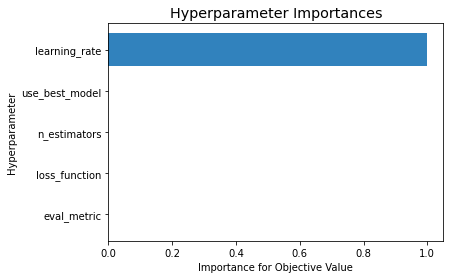

In [34]:
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

plot_param_importances(study_cat);

#### Вывод:

Наиболее важным параметром является скорость

Так как из трех моделей явно видно какой из них лучше, то используя его, можно составить рейтинг влияющих факторов на формирование коэффициента, используя метод permutation_importance

In [35]:
from sklearn.inspection import permutation_importance

In [36]:
# подсчет категориальных признаков
r = permutation_importance(cat_optuna,
                           X_test,
                           y_test,
                           n_repeats=4,
                           random_state=RAND)

In [37]:
feature_imp = pd.DataFrame()
feature_imp['column'] = X_test.columns
feature_imp['value'] = r['importances_mean']
feature_imp['2_std'] = 2*r['importances_std']

feature_imp.sort_values(by='value', inplace=True, ascending=False)

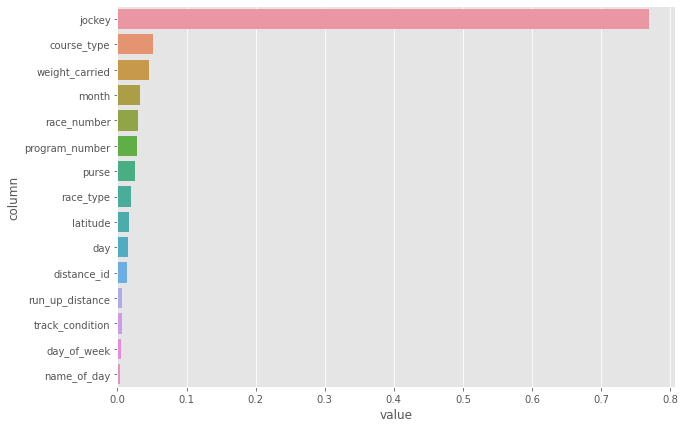

In [38]:
plt.figure(figsize=(10, 7))
sns.barplot(data=feature_imp[:15], x='value', y='column');

#### Вывод:

Самые влияющие факторы это:
- жокей;
- тип трассы;
- вес на лошади;
- месяц; 
- лошадь и т.д.

Зная самые влияющие признаки, можно посмотреть значения коэффициента odds_log в них.

1. Жокей

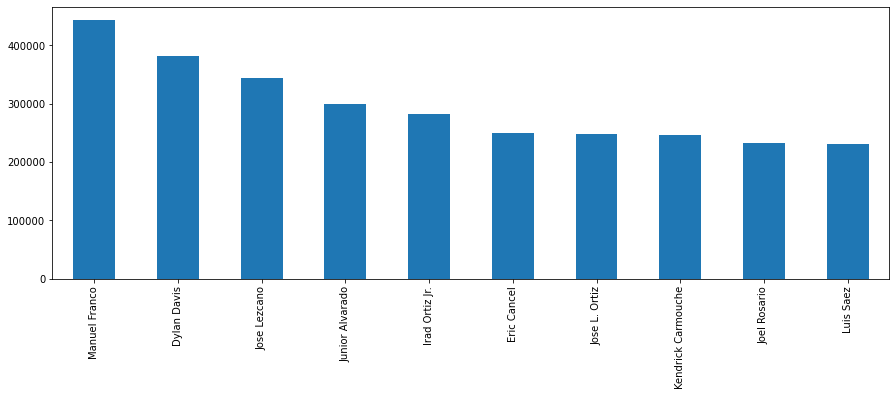

In [125]:
df.jockey.value_counts()[0:10].plot(kind='bar',figsize=(15,5));

Жокеев очень много. Можно посмотреть на распределения значений коэффициента топ-3 жокеев.

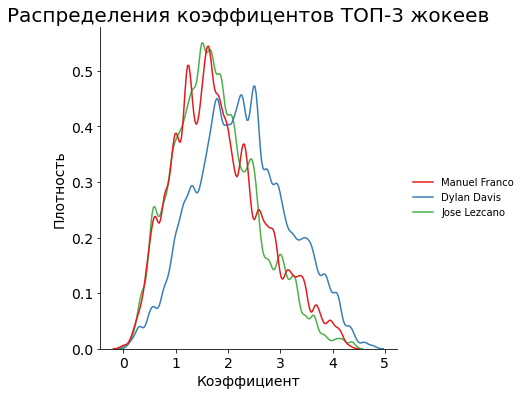

In [126]:
sns.displot(
    {
        "Manuel Franco": df[df.jockey == 'Manuel Franco'].odds_log,
        "Dylan Davis": df[df.jockey == 'Dylan Davis'].odds_log,
        "Jose Lezcano": df[df.jockey == 'Jose Lezcano'].odds_log
    },
    kind="kde",
    common_norm=False,
    palette='Set1'
)

plt.title('Распределения коэффицентов ТОП-3 жокеев', fontsize=20)
plt.xlabel('Коэффициент', fontsize=14)
plt.ylabel('Плотность', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

По графику видно, что жокей влияет на формирование коэффициента. У Manuel Franco и Jose Lezcano коэффициенты получше, чем у Dylan Davis, хоть он и второй по количеству участий в гонках.

2. Тип трассы

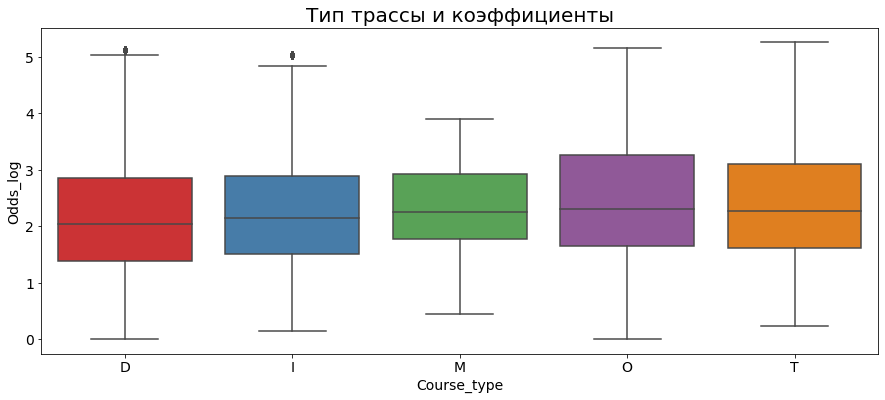

In [104]:
plt.figure(figsize=(15, 6))

sns.boxplot(x='course_type', y='odds_log', 
            data=df, palette='Set1')

plt.title('Тип трассы и коэффициенты', fontsize=20)
plt.ylabel('Odds_log', fontsize=14)
plt.xlabel('Course_type', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

В среднем коэффициенты +/- одинаковые. Чуть больше коэффициенты на трассе О (внешний газон), лучше коэффициенты на трассе D (грязь).

3. Вес на лошади

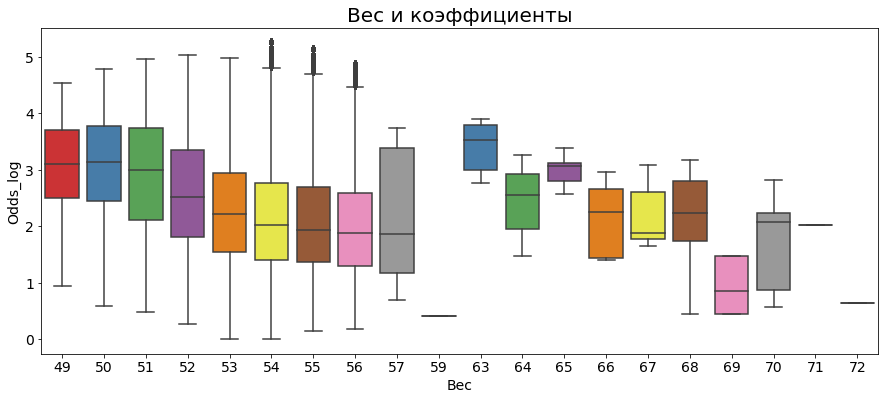

In [119]:
plt.figure(figsize=(15, 6))

sns.boxplot(x='weight_carried', y='odds_log', 
            data=df, palette='Set1')

plt.title('Вес и коэффициенты', fontsize=20)
plt.ylabel('Odds_log', fontsize=14)
plt.xlabel('Вес', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

До 59 кг видно, как с увеличением веса улучшается коэффициент. 

А начиная с 63 кг закономерности не наблюдается.

4. Месяц

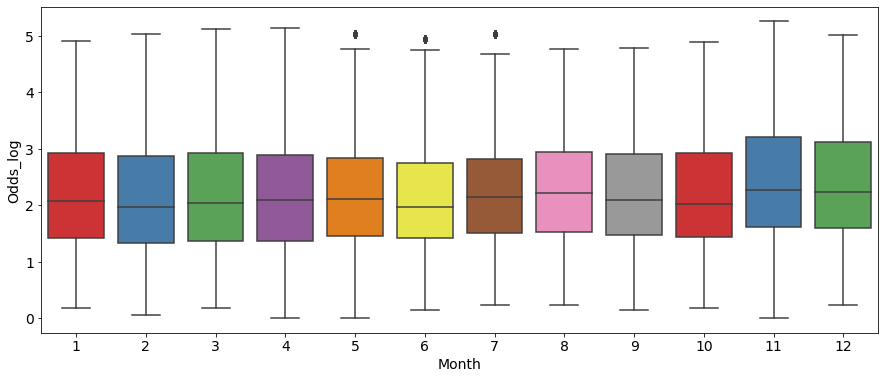

In [121]:
plt.figure(figsize=(15, 6))

sns.boxplot(x='month', y='odds_log', data=df,
            palette='Set1')

plt.ylabel('Odds_log', fontsize=14)
plt.xlabel('Month', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Лучше коэффициенты в феврале(2), июне (6). Похуже в ноябре (11).

5. Лошадь

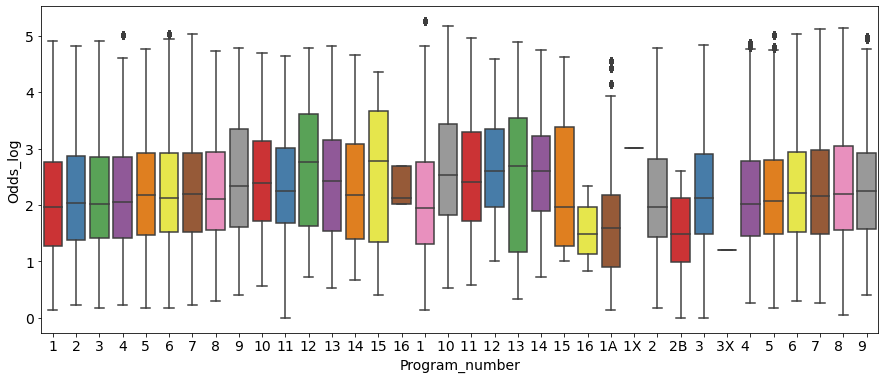

In [123]:
plt.figure(figsize=(15, 6))

sns.boxplot(x='program_number', y='odds_log', data=df, 
            palette='Set1')

plt.ylabel('Odds_log', fontsize=14)
plt.xlabel('Program_number', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Как ранее было написано в EDA-анализе: 1X, 3X 16, 2B - совсем новички. 

Чем больше диапазон, тем больше раз лошадь принимала участие в соревнованиях.